### Проект выполнил
Ф.И.О Мирошкин Ярослав Андреевич <br>
Telegram - https://t.me/MiroshkinYaroslav

## Описание проекта

## Цели
* Разработать модель машинного обучения позволяющую предсказать необходимый уровень английского языка для просмотра фильма 
## Описание данных

# English Score


In [84]:
import os
import pysrt as srt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import pickle
import optuna
import pprint
import re
import tensorflow as tf
import warnings

import lightgbm as lgb

import nltk
from nltk.corpus import stopwords

from catboost import CatBoostClassifier, Pool

from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfTransformer,
                                             TfidfVectorizer)
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix,
    f1_score, roc_auc_score,
    classification_report, make_scorer,
    precision_recall_fscore_support,
    accuracy_score

)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (RandomizedSearchCV,
GridSearchCV)
from sklearn.neighbors import  KNeighborsClassifier

from transformers import TFAutoModel, AutoTokenizer

from datasets import load_dataset


warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('punkt')

STATE = 0
N_FOLDS = 3

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\miroshkin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\miroshkin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cmp = ConfusionMatrixDisplay(cm)
    cmp.plot()


In [49]:
def my_bar(data: pd.Series, dropna=True, title='', xlabel='', ylabel=''):
    distribution = data.value_counts(dropna=dropna, normalize=False)
    distribution_normalized = data.value_counts(dropna=dropna, normalize=True)
    _, ax = plt.subplots(1)
    sns.barplot(x=distribution_normalized.index, y=distribution_normalized.values).set(
    title=title, xlabel=xlabel, ylabel=ylabel)
    for a, p in enumerate(ax.patches):
        text = str(distribution.iloc[a])
        ax.annotate(text, xy=(p.get_x() + p.get_width() / 2, 0.8 * p.get_height()), \
        size=13, color='black', ha = 'center', va = 'center',
        bbox = dict(boxstyle = 'round',\
        facecolor='none',edgecolor='black', alpha = 0.5) )

def my_kde(df: pd.DataFrame(), col=''):
    f, (ax_kde, ax_box) = plt.subplots(2, gridspec_kw={"height_ratios": (0.85, 0.15)}, sharex=True)
    sns.kdeplot(df, alpha=0.3, fill=True, color='green', ax=ax_kde)
    ax_kde.set(xlabel='', yticks=[])
    ax_kde.set_title(col, fontsize=16)
    sns.boxplot(data=df, orient='h', ax=ax_box, color='green')
    plt.subplots_adjust(hspace=0)
    ax_box.set_xlabel('')

def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    mae_train = metric_fun(y_train, y_pred_train, average='macro')
    mae_test = metric_fun(y_test, y_pred_test, average='macro')

    print(f'{metric_fun.__name__} train: %.3f' % mae_train)
    print(f'{metric_fun.__name__} test: %.3f' % mae_test)
    print(f'delta = {(abs(mae_train - mae_test)/mae_train*100):.1f} %')

def get_metrics(y_true, y_pred, name='None', metrics=None):
    presision, recall, f1, sup = precision_recall_fscore_support(y_test, 
                            y_pred)
    presision, recall, f1 = presision.mean(), recall.mean(), f1.mean()
    result = pd.DataFrame(data={'precision': presision,
                                'recall': recall,
                                'f1_score': f1,
                                'accuracy': accuracy_score(y_true, y_pred)}, 
                                index=[name]).round(2)
    if metrics is None:
        return result
    else:
        return pd.concat([metrics, result], axis=0)

### Парсинг данных и чтение данных

In [4]:
movies_labels = pd.read_excel('english_scores\movies_labels.xlsx', index_col='Movie').drop('id', axis=1)
paths = ['english_scores/subtitles_all/subtitles/',
         'english_scores/subtitles_all/A2/',
         'english_scores/subtitles_all/B1/',
         'english_scores/subtitles_all/B2/',
         'english_scores/subtitles_all/C1/',
         'subtitles/']
data = {}
for path in paths:
    for sub_name in os.listdir(path[:-1]):
        try:
            subs = srt.open(path + sub_name, encoding='utf-8')
        except:
            subs = srt.open(path + sub_name, encoding='ISO-8859-1')
        sub_list = " ".join([sub.text for sub in subs])
        data[sub_name[:-4]] = sub_list


In [5]:
df = pd.DataFrame(data.values(), index=data.keys(), columns=['subtitle'])
df.head(3)

,subtitle
10_Cloverfield_lane(2016),"<font color=""#ffff80""><b>Fixed & Synced by boz..."
10_things_I_hate_about_you(1999),"Hey! I'll be right with you. So, Cameron. Here..."
Aladdin(1992),"<i>Oh, I come from a land\nFrom a faraway plac..."


Получен датасет, где:<br>
индексы - названия фильмов<br>
subtitle - субтитры в строков формате <br><br>
Оценим общее количество символов в "сыром датасете"

In [6]:
print(f'Общее количество символов в субтитрах: {df.subtitle.str.len().sum():,.0f}')

Общее количество символов в субтитрах: 11,277,626


### Добавление и обработка разметки

Добавим в датасет разметку

In [7]:
movies_labels.head(3)

,Level
Movie,
10_Cloverfield_lane(2016),B1
10_things_I_hate_about_you(1999),B1
A_knights_tale(2001),B2


In [8]:
print(f'Количество файлов субтитров: {df.subtitle.count()}\n\
Количество строк в разметке: {movies_labels.Level.count()}')

Количество файлов субтитров: 279
Количество строк в разметке: 241


Часть данных не размечена

In [9]:
df = df.join(movies_labels)
df = df.rename(columns={'Level': 'level'})
df.head(2)

,subtitle,level
10_Cloverfield_lane(2016),"<font color=""#ffff80""><b>Fixed & Synced by boz...",B1
10_things_I_hate_about_you(1999),"Hey! I'll be right with you. So, Cameron. Here...",B1


Проанализируем баланс классов в `level`

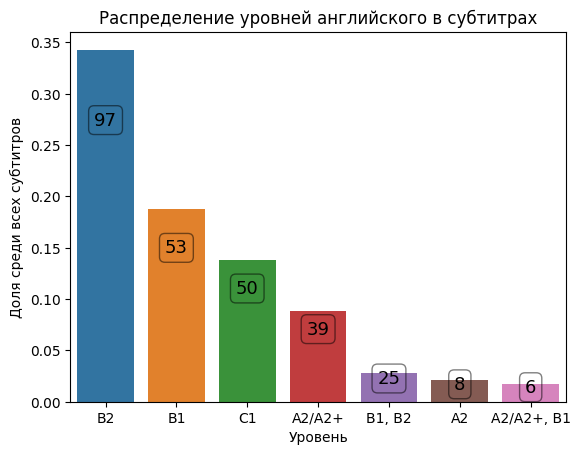

In [10]:
my_bar(df.level, dropna=False, title='Распределение уровней английского в субтитрах',\
        xlabel='Уровень', ylabel='Доля среди всех субтитров')

Оставим 4 основных уровня знания языка:
* A2, A2+ - Beginner, Elementary 
* B1 - Intermediate 
* B2 - Upper-Intermediate 
* C1 - Advanced


In [11]:
df = df.replace({'level' :{'B1, B2': 'B1',
                      'A2': 'A2/A2+',
                      'A2/A2+, B1': 'A2/A2+'}})

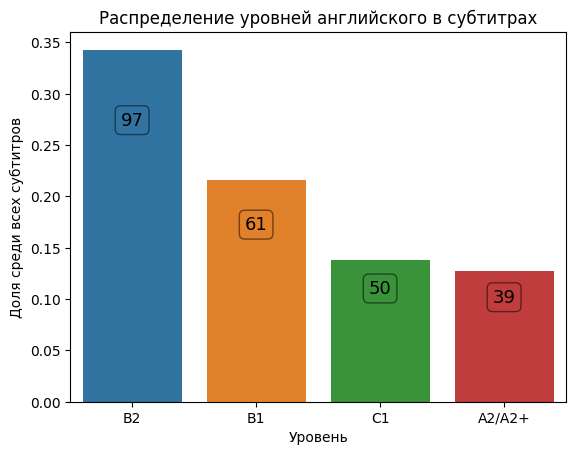

In [12]:
my_bar(df.level, dropna=False, title='Распределение уровней английского в субтитрах',\
        xlabel='Уровень', ylabel='Доля среди всех субтитров')

Присутствует дисбаланс классов <br><br>
Удалим неразмеченные данные

In [13]:
df = df.dropna(subset='level', axis=0)

Заменим уровни знания языка числовыми параметрами в порядке возрастания.
* A2, A2+ - 0
* B1 - 1
* B2 - 2 
* C1 - 3

In [14]:
df.level = df.level.replace({'A2/A2+': 0,
                  'B1': 1,
                  'B2': 2,
                  'C1': 3})

### Обработка данных

#### Приведение к нижнему регистру, обработка спецсимволов и "стоп-слов"

In [15]:
# Пример "стоп-слов"
np.array(stopwords.words('english'))[:20]

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his'], dtype='<U10')

In [16]:
def preprocess_text(data, stopwords=stopwords.words('english')):
    #Приводим к нижему регистру
    text = data.lower()
    #Удаляем все символы между <>, '<some symbols>' -> ''
    text = re.sub('<[^>]+>', '', text)
    #Добавляем пробелы между знаками препинания
    text = re.sub(r"([.,!?])", r" \1 ", text)
    # удаляем пробелы в начале и в конце предложения
    text = text.strip()
    #Удаляем слова в скобках
    text = re.sub(r'\([^)]*\)', '', text)
    # Оставляем только латинские буквы
    text = re.sub(r'[^a-z]', ' ', text)
    # удаление стоп-слов
    text = [w for w in text.split() if w not in stopwords]
    # удаляем слова короче 3х символов
    text = [w for w in text if len(w) >= 3]
    return ' '.join(text)

In [17]:
df.subtitle = df.subtitle.apply(lambda text: preprocess_text(text))

#### Стемминг и лемматизация

In [18]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [19]:
flag = 0
if flag:
    df['lemma_clear_text'] = df.subtitle.apply(lambda row: lemmatize(row))
else:
    with open('df_lemma.pickle', 'rb') as file:
        df = pickle.load(file)

In [20]:
df = df.loc[~(df.lemma_clear_text=='')]

In [21]:
features = df.lemma_clear_text
target = df.level

In [22]:
X_train, X_test, y_train, y_test = train_test_split(features, target,\
                                 test_size=0.25, random_state=STATE, shuffle=True)

### Оценка количества слов в субтитрах

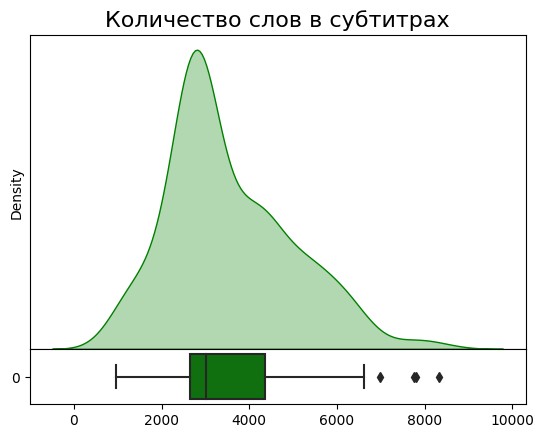

In [23]:
my_kde(df.lemma_clear_text.apply(lambda x: len(x.split())), 
       col='Количество слов в субтитрах')

### Векторизация

In [24]:
corpus_train = X_train.values
corpus_test = X_test.values

In [25]:
tfidf = TfidfVectorizer()
tf_idf_train = tfidf.fit_transform(corpus_train)
tf_idf_test = tfidf.transform(corpus_test)

### Моделирование

### Dummy model 
Предсказание наиболее популярного класса

In [42]:
print(classification_report(y_test, 2 * np.ones(len(y_test))))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00        16
           2       0.45      1.00      0.62        25
           3       0.00      0.00      0.00         5

    accuracy                           0.45        55
   macro avg       0.11      0.25      0.16        55
weighted avg       0.21      0.45      0.28        55



In [44]:
metrics = get_metrics(y_test, 2 * np.ones(len(y_test)), 'dummy_model')
metrics

,precision,recall,f1_score,accuracy
dummy_model,0.11,0.25,0.16,0.45


### LogisticRegression Tuning

In [26]:
lr = LogisticRegression(random_state=STATE, class_weight='balanced')
params_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 1.0, 10.0, 100.0]
}
grid_lr = GridSearchCV(estimator=lr, 
                    param_grid=params_lr, 
                    cv=5, 
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1)

In [27]:
grid_lr.fit(tf_idf_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.01, 1.0, 10.0, 100.0],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=1)

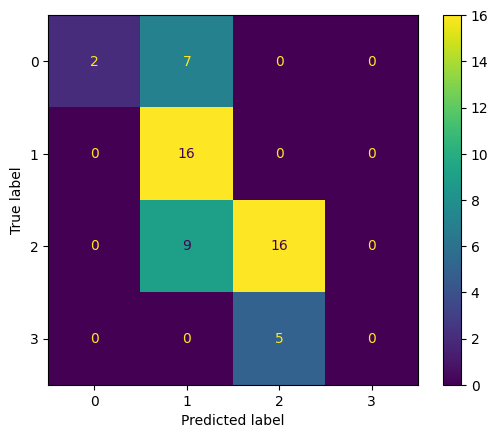

In [28]:
plot_confusion_matrix(y_test, 
                      grid_lr.best_estimator_.predict(tf_idf_test))

In [29]:
print(classification_report(y_test, 
                      grid_lr.best_estimator_.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       1.00      0.22      0.36         9
           1       0.50      1.00      0.67        16
           2       0.76      0.64      0.70        25
           3       0.00      0.00      0.00         5

    accuracy                           0.62        55
   macro avg       0.57      0.47      0.43        55
weighted avg       0.66      0.62      0.57        55



In [46]:
metrics = get_metrics(y_test, 
                      grid_lr.best_estimator_.predict(tf_idf_test),
                      name='LogisticRegression', metrics=metrics)
metrics

,precision,recall,f1_score,accuracy
dummy_model,0.11,0.25,0.16,0.45
LogisticRegression,0.57,0.47,0.43,0.62


In [50]:
check_overfitting(grid_lr.best_estimator_, 
                  tf_idf_train, y_train, 
                  tf_idf_test, y_test, f1_score)

f1_score train: 0.938
f1_score test: 0.431
delta = 54.0 %


### RandomForestClassifier Tuning

In [32]:
flag = 0
if flag:
    rfc = RandomForestClassifier(random_state=STATE)
    params_rfc = {
    'max_depth': range(8, 25, 2),
    'n_estimators': range(40, 161, 30),
    'class_weight': ['balanced', 'balanced_subsample'],
    'min_samples_split': range(2,5,1)
    }
    grid_rfc = GridSearchCV(estimator=rfc, 
                            param_grid=params_rfc,
                            n_jobs=-1, 
                            )
    grid_rfc.fit(tf_idf_train, y_train)
else:
    with open('content/grid_rfc.pickle', 'rb') as file:
        grid_rfc = pickle.load(file)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


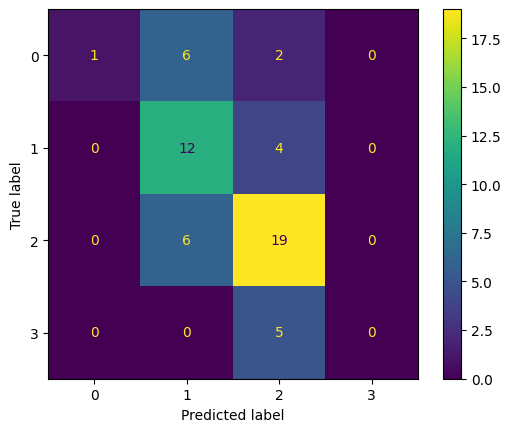

In [33]:
plot_confusion_matrix(y_test, y_pred=grid_rfc.best_estimator_.predict(tf_idf_test))

In [34]:
print(classification_report(y_test, 
                            y_pred=grid_rfc.best_estimator_.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.50      0.75      0.60        16
           2       0.63      0.76      0.69        25
           3       0.00      0.00      0.00         5

    accuracy                           0.58        55
   macro avg       0.53      0.41      0.37        55
weighted avg       0.60      0.58      0.52        55



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


In [35]:
metrics = get_metrics(y_test, 
                      grid_rfc.best_estimator_.predict(tf_idf_test),
                      name='RandomForesClassifier', metrics=metrics)
metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


,precision,recall,f1_score,accuracy
LogisticRegression,0.57,0.47,0.43,0.62
RandomForesClassifier,0.53,0.41,0.37,0.58


In [51]:
check_overfitting(grid_rfc.best_estimator_, 
                  tf_idf_train, y_train, 
                  tf_idf_test, y_test, f1_score)

f1_score train: 0.993
f1_score test: 0.373
delta = 62.5 %


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


### LightGBM Tuning

In [36]:
flag = 0
if flag:
    lgb_model = lgb.LGBMClassifier(random_state=STATE, class_weight='balanced')
    params_lgb = {
    'num_leaves': range(40, 120),
    'max_depth': range(4, 13, 2),
    'max_bin': range(20, 51, 10),
    'num_iterations': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1]
    }
    grid_lgb = RandomizedSearchCV(estimator=lgb_model,
                            param_distributions=params_lgb,
                            n_jobs=-1, verbose=2, n_iter=1_000, random_state=STATE
                            )
    grid_lgb.fit(tf_idf_train, y_train)
else:
    with open('content/grid_lgb.pickle', 'rb') as file:
        grid_lgb = pickle.load(file)

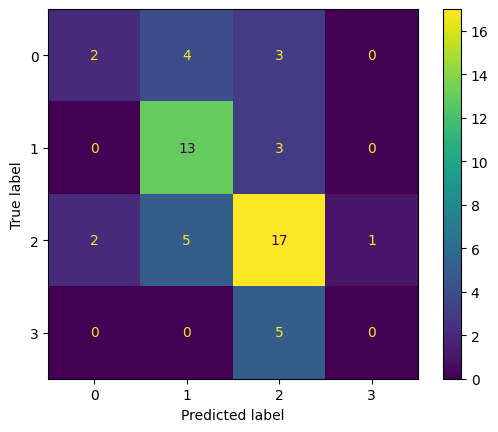

In [37]:
plot_confusion_matrix(y_test, grid_lgb.best_estimator_.predict(tf_idf_test))

In [38]:
print(classification_report(y_test, 
                            grid_lgb.best_estimator_.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       0.50      0.22      0.31         9
           1       0.59      0.81      0.68        16
           2       0.61      0.68      0.64        25
           3       0.00      0.00      0.00         5

    accuracy                           0.58        55
   macro avg       0.42      0.43      0.41        55
weighted avg       0.53      0.58      0.54        55



In [39]:
metrics = get_metrics(y_test, 
                      grid_lgb.best_estimator_.predict(tf_idf_test),
                      name='LightGBM', metrics=metrics)
metrics

,precision,recall,f1_score,accuracy
LogisticRegression,0.57,0.47,0.43,0.62
RandomForesClassifier,0.53,0.41,0.37,0.58
LightGBM,0.42,0.43,0.41,0.58


In [52]:
check_overfitting(grid_lgb.best_estimator_, 
                  tf_idf_train, y_train, 
                  tf_idf_test, y_test, f1_score)

f1_score train: 0.993
f1_score test: 0.408
delta = 58.9 %


### CatBoostClassifier `GPU` Baseline

In [63]:
flag = 0
if flag:
    cbc_gpu_baseline = CatBoostClassifier(random_state=STATE,  task_type='GPU',
                                          max_depth=8)
    cbc_gpu_baseline.fit(tf_idf_train, y_train)
    with open('content/cbc_gpu_baseline.pickle', 'wb') as file:
        pickle.dump(cbc_gpu_baseline,file)
else:
    with open('content/cbc_gpu_baseline.pickle', 'rb') as file:
        cbc_gpu = pickle.load(file)

In [64]:
print(classification_report(y_test, cbc_gpu_baseline.predict(tf_idf_test)))

              precision    recall  f1-score   support

           0       0.50      0.11      0.18         9
           1       0.56      0.94      0.70        16
           2       0.83      0.80      0.82        25
           3       1.00      0.40      0.57         5

    accuracy                           0.69        55
   macro avg       0.72      0.56      0.57        55
weighted avg       0.71      0.69      0.66        55



In [65]:
metrics = get_metrics(y_test, 
                      cbc_gpu_baseline.predict(tf_idf_test),
                      name='Catboost_baseline', metrics=metrics)
metrics

,precision,recall,f1_score,accuracy
dummy_model,0.11,0.25,0.16,0.45
LogisticRegression,0.57,0.47,0.43,0.62
Catboost_baseline,0.72,0.56,0.57,0.69
Catboost_baseline,0.72,0.56,0.57,0.69


In [66]:
check_overfitting(cbc_gpu_baseline, 
                  tf_idf_train, y_train, 
                  tf_idf_test, y_test, f1_score)

f1_score train: 0.993
f1_score test: 0.567
delta = 42.9 %


### CatBoostClassifier `GPU` Optuna

In [98]:
def objective(trial, X, y, N_FOLDS, random_state=0):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 8),
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=STATE)
    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        train_data = Pool(data=X_train, label=y_train)
        eval_data = Pool(data=X_test, label=y_test)
        
        model = CatBoostClassifier(**params, task_type='GPU')
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = f1_score(y_test, preds, average='macro')

    return np.mean(cv_predicts[idx])

In [99]:
study_cat = optuna.create_study(direction="maximize", study_name="cbc")
def func_cat(trial):
    return objective(trial,
                         X=pd.DataFrame.sparse.from_spmatrix(tf_idf_train),
                         y=y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=STATE)
study_cat.optimize(func_cat, n_trials=3, show_progress_bar=True)

[I 2023-06-28 19:24:34,725] A new study created in memory with name: cbc
Best trial: 0. Best value: 0.537527:  33%|███▎      | 1/3 [01:40<03:21, 100.58s/it]

[I 2023-06-28 19:26:15,307] Trial 0 finished with value: 0.5375274521548159 and parameters: {'learning_rate': 0.0019218358313942726, 'depth': 4}. Best is trial 0 with value: 0.5375274521548159.


Best trial: 1. Best value: 0.623052:  67%|██████▋   | 2/3 [06:07<03:18, 198.51s/it]

[I 2023-06-28 19:30:42,362] Trial 1 finished with value: 0.623051933037366 and parameters: {'learning_rate': 0.0032734742033373584, 'depth': 7}. Best is trial 1 with value: 0.623051933037366.


Best trial: 1. Best value: 0.623052: 100%|██████████| 3/3 [07:18<00:00, 146.28s/it]

[I 2023-06-28 19:31:53,578] Trial 2 finished with value: 0.5621513461072035 and parameters: {'learning_rate': 0.013392759699408032, 'depth': 3}. Best is trial 1 with value: 0.623051933037366.


In [80]:
study_cat.best_value

0.6067886817015737

In [81]:
study_cat.best_trial

FrozenTrial(number=1, state=TrialState.COMPLETE, values=[0.6067886817015737], datetime_start=datetime.datetime(2023, 6, 28, 19, 7, 32, 322990), datetime_complete=datetime.datetime(2023, 6, 28, 19, 7, 50, 633000), params={'learning_rate': 0.06850569429907903, 'depth': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'depth': IntDistribution(high=8, log=False, low=1, step=1)}, trial_id=1, value=None)

In [100]:
study_cat.best_params

{'learning_rate': 0.0032734742033373584, 'depth': 7}

## BERT

In [80]:
from bert_dataset import CustomDataset
from bert_classifier import BertClassifier

In [81]:
model = TFAutoModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [82]:
classifier = BertClassifier(
        model_path='bert-large-uncased',
        tokenizer_path='bert-large-uncased',
        n_classes=y_train.nunique(),
        epochs=2,
        model_save_path='content/bert_large.pt'
)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

In [75]:
classifier.preparation(
        X_train=list(X_train),
        y_train=list(y_train),
        X_valid=list(X_test),
        y_valid=list(y_test)
    )

c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [76]:
%time
classifier.train()

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/2
Train loss 1.3089609173522598 accuracy 0.3850574712643678
Val loss 1.1711469054222108 accuracy 0.5254237288135594
----------
Epoch 2/2
Train loss 1.2307004681092568 accuracy 0.4367816091954023
Val loss 1.1384449392557143 accuracy 0.5254237288135594
----------


In [81]:
y_pred = [classifier.predict(t) for t in X_test]

In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00        14
           2       0.48      1.00      0.65        26
           3       1.00      0.50      0.67        10

    accuracy                           0.53        59
   macro avg       0.37      0.38      0.33        59
weighted avg       0.38      0.53      0.40        59



c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\miroshkin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf